In [1]:
# Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from tensorflow.keras import backend as K

In [3]:
# Directories

In [4]:
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)

In [5]:
(x_train, _), (x_test, _) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [6]:
# Visualize sample clean images

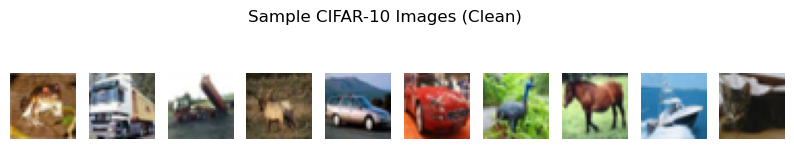

In [7]:
plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(x_train[i])
    plt.axis('off')
plt.suptitle("Sample CIFAR-10 Images (Clean)")
plt.show()

In [8]:
# Add Noise

In [9]:
def add_noise(data, mode='gaussian', var=0.01, amount=0.02):
    if mode == 'gaussian':
        noisy = random_noise(data, mode='gaussian', var=var)
    elif mode == 's&p':
        noisy = random_noise(data, mode='s&p', amount=amount)
    else:
        noisy = data
    noisy = np.clip(noisy, 0., 1.)
    return noisy

x_train_noisy = add_noise(x_train, 'gaussian', 0.01)
x_test_noisy = add_noise(x_test, 'gaussian', 0.01)

In [10]:
# Visualize noisy vs clean

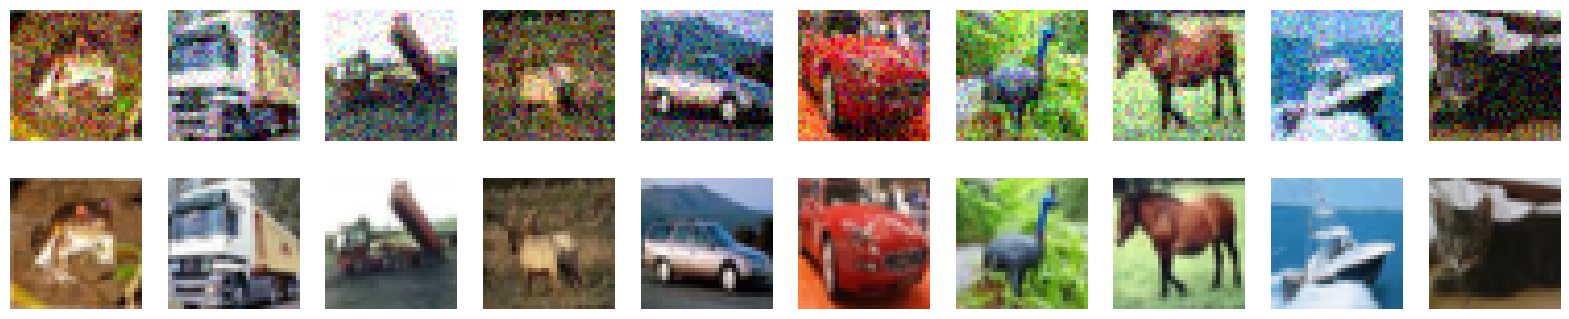

In [11]:
plt.figure(figsize=(20,4))
for i in range(10):
    # Noisy
    ax = plt.subplot(2,10,i+1)
    plt.imshow(x_train_noisy[i])
    plt.axis('off')
    if i==0: plt.ylabel("Noisy")
    # Original
    ax = plt.subplot(2,10,i+11)
    plt.imshow(x_train[i])
    plt.axis('off')
    if i==0: plt.ylabel("Clean")
plt.show()

In [12]:
# Autoecoder

In [13]:
def residual_block(x, filters):
    conv = Conv2D(filters, (3,3), padding='same', activation='relu')(x)
    conv = BatchNormalization()(conv)
    conv = Conv2D(filters, (3,3), padding='same', activation='relu')(conv)
    conv = BatchNormalization()(conv)
    out = Add()([x, conv])
    return out

input_img = Input(shape=(32,32,3))

In [14]:
# Encoder

In [15]:
x = Conv2D(64, (3,3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = residual_block(x, 64)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

In [16]:
# Decoder

In [17]:
x = Conv2D(128, (3,3), activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
x = UpSampling2D((2,2))(x)
x = residual_block(x, 128)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

In [18]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(0.001), loss='mse')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 32, 32, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 32, 32, 64)        │           1,792 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 32, 32, 64)        │             256 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 16, 16, 64)        │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 16, 16, 64)        │          36,928 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 16, 16, 64)        │             256 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 16, 16, 64)        │          36,928 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 16, 16, 64)        │             256 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 16, 16, 64)        │               0 │ max_pooling2d[0][0],       │
│                               │                           │                 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 16, 16, 128)       │          73,856 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 16, 16, 128)       │             512 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 8, 8, 128)         │               0 │ batch_normalization_3[0][… │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 8, 8, 128)         │         147,584 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_4         │ (None, 8, 8, 128)         │             512 │ conv2d_4[0][0]             │
│ (BatchNormalization)          │                           │               

 Total params: 670,851 (2.56 MB)

 Trainable params: 669,315 (2.55 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [19]:
#Training

In [ ]:
checkpoint = ModelCheckpoint("models/denoiser.keras", save_best_only=True)
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[checkpoint, early_stop]
)

Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 457s 1s/step - loss: 0.0123 - val_loss: 0.0113
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 404s 1s/step - loss: 0.0038 - val_loss: 0.0035
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 406s 1s/step - loss: 0.0030 - val_loss: 0.0032
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 405s 1s/step - loss: 0.0027 - val_loss: 0.0027
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 446s 1s/step - loss: 0.0025 - val_loss: 0.0024
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 490s 1s/step - loss: 0.0024 - val_loss: 0.0022
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 492s 1s/step - loss: 0.0023 - val_loss: 0.0021
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 490s 1s/step - loss: 0.0022 - val_loss: 0.0021
Epoch 9/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 490s 1s/step - loss: 0.0022 - val_loss: 0.0028
Epoch 10/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 17837s 46s/step - loss: 0.0022 - val_loss: 0.0020
Epoch 11/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 429s 1s/step - loss: 0.0021 - val_loss: 0.0023
Epoch 12/100
391/391 ━━━━━━

In [ ]:
# Training curves

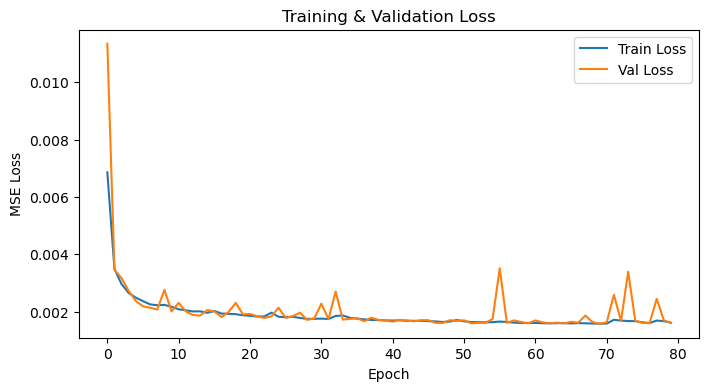

In [37]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

In [29]:
# Evaluate Denoising

In [41]:
preds = autoencoder.predict(x_test_noisy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 113ms/step


In [32]:
# PSNR & SSIM

In [61]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np
import seaborn as sns

psnr_values, ssim_values = [], []

for i in range(len(x_test)):
    img1, img2 = x_test[i], preds[i]

    # If shape is (C,H,W) → convert to (H,W,C)
    if img1.ndim == 3 and img1.shape[0] in [1, 3]:
        img1 = np.transpose(img1, (1, 2, 0))
        img2 = np.transpose(img2, (1, 2, 0))

    # Ensure values are float32 in [0,1]
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)

    psnr_values.append(psnr(img1, img2, data_range=1.0))
    ssim_values.append(ssim(img1, img2, channel_axis=-1, win_size=3, data_range=1.0))

print("Average PSNR:", np.mean(psnr_values))
print("Average SSIM:", np.mean(ssim_values))


Average PSNR: 28.264173096471296
Average SSIM: 0.84040344


In [45]:
# PSNR histogram

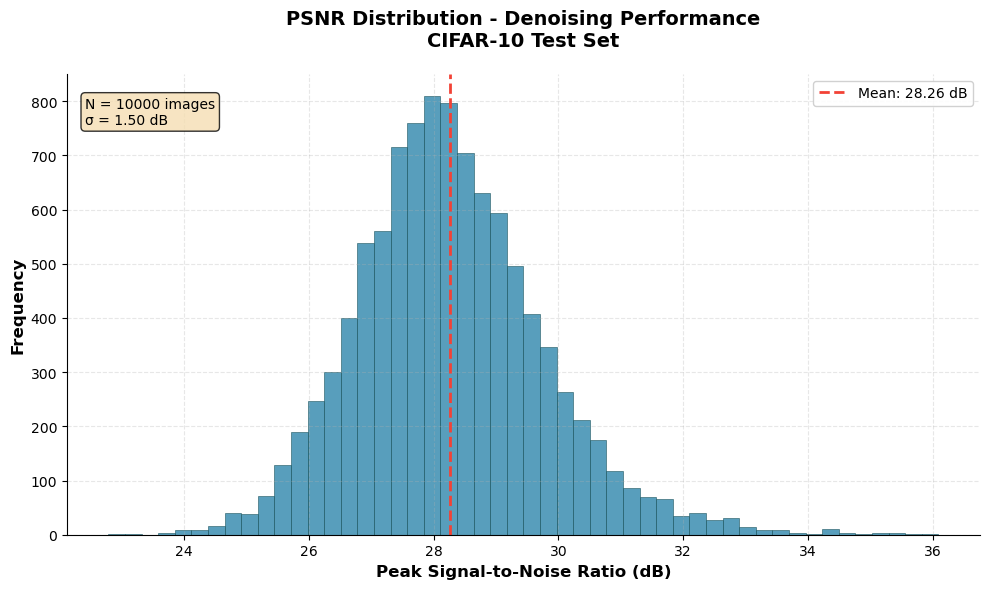

In [63]:

plt.figure(figsize=(10, 6))
plt.hist(psnr_values, bins=50, color='#2E86AB', edgecolor='#1A535C', linewidth=0.5, alpha=0.8)

# Add vertical line for mean
mean_psnr = np.mean(psnr_values)
plt.axvline(mean_psnr, color='#F24236', linestyle='--', linewidth=2, 
            label=f'Mean: {mean_psnr:.2f} dB')

# Professional styling
plt.title('PSNR Distribution - Denoising Performance\nCIFAR-10 Test Set', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Peak Signal-to-Noise Ratio (dB)', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')

# Add grid and improve ticks
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add some statistics in the plot
plt.text(0.02, 0.95, f'N = {len(psnr_values)} images\nσ = {np.std(psnr_values):.2f} dB', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Legend and layout
plt.legend(fontsize=10, framealpha=0.9)
plt.tight_layout()

# Remove spines for cleaner look
sns.despine()

plt.show()

In [49]:
# SSIM histogram

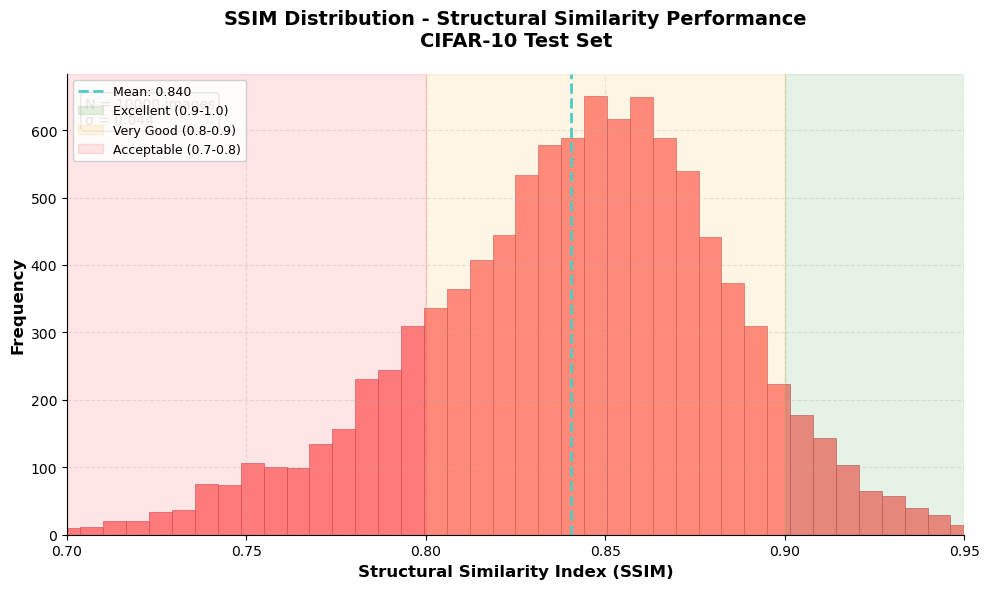

In [71]:
plt.figure(figsize=(10, 6))
plt.hist(ssim_values, bins=50, color='#FF6B6B', edgecolor='#C44D58', linewidth=0.5, alpha=0.8)

# Add vertical line for mean
mean_ssim = np.mean(ssim_values)
plt.axvline(mean_ssim, color='#4ECDC4', linestyle='--', linewidth=2, 
            label=f'Mean: {mean_ssim:.3f}')

# Professional styling
plt.title('SSIM Distribution - Structural Similarity Performance\nCIFAR-10 Test Set', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Structural Similarity Index (SSIM)', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')

# Set x-axis limits for better focus (SSIM is 0-1)
plt.xlim(0.7, 0.95)

# Add grid and improve ticks
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(np.arange(0.7, 0.96, 0.05), fontsize=10)
plt.yticks(fontsize=10)

# Add some statistics in the plot
plt.text(0.02, 0.95, f'N = {len(ssim_values)} images\nσ = {np.std(ssim_values):.3f}', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Add SSIM quality reference lines
plt.axvspan(0.9, 0.95, alpha=0.1, color='green', label='Excellent (0.9-1.0)')
plt.axvspan(0.8, 0.9, alpha=0.1, color='orange', label='Very Good (0.8-0.9)')
plt.axvspan(0.7, 0.8, alpha=0.1, color='red', label='Acceptable (0.7-0.8)')

# Legend and layout
plt.legend(fontsize=9, framealpha=0.9, loc='upper left')
plt.tight_layout()

# Remove spines for cleaner look
sns.despine()

plt.show()

In [67]:
# Visualize Results

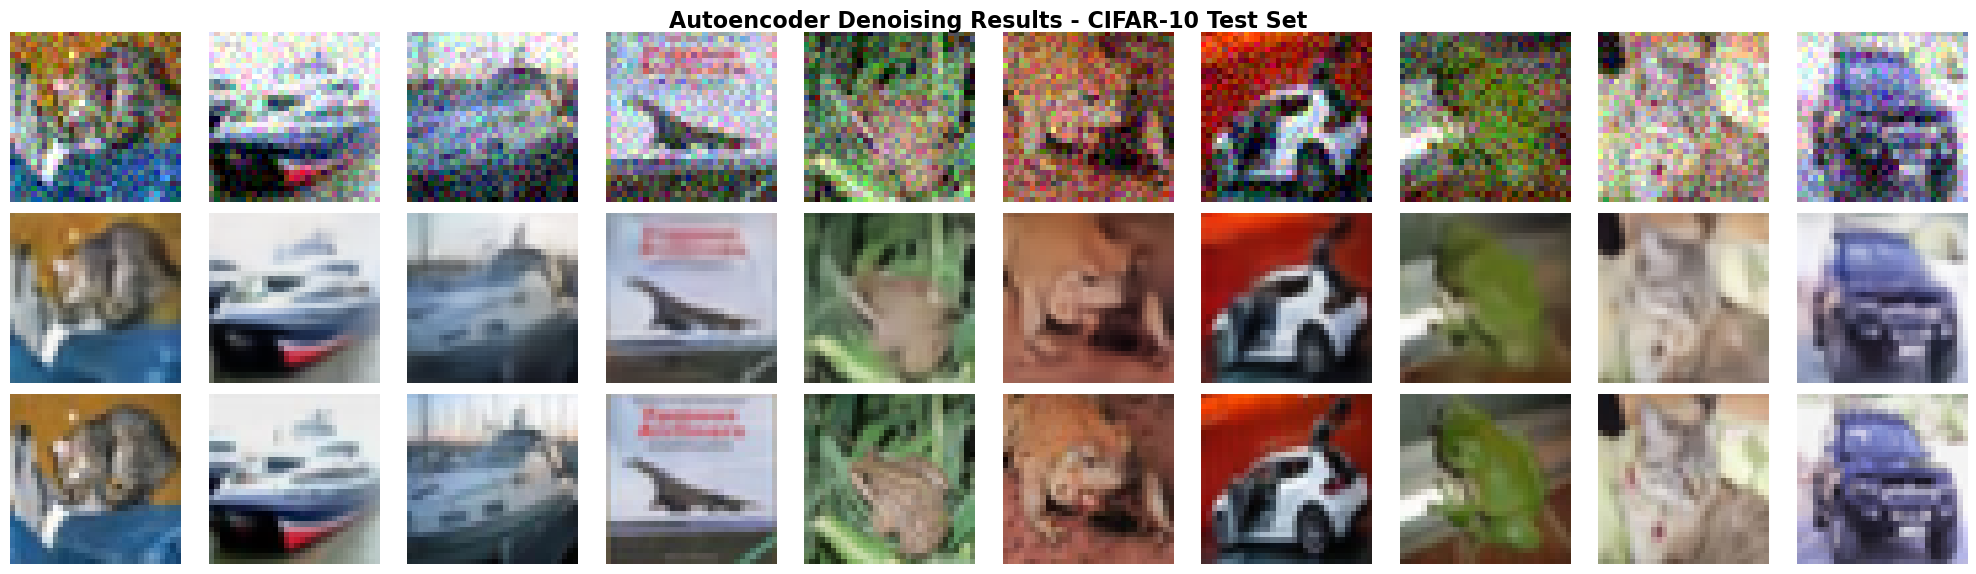

In [73]:
n = 10
plt.figure(figsize=(20, 6))

for i in range(n):
    # Noisy
    ax = plt.subplot(3, n, i+1)
    plt.imshow(x_test_noisy[i])
    plt.axis('off')
    if i == 0: 
        plt.ylabel("Noisy\nInput", fontsize=14, fontweight='bold', labelpad=20)
    
    # Denoised (YOUR RESULTS!)
    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(preds[i])
    plt.axis('off')
    if i == 0:
        plt.ylabel("Denoised\nOutput", fontsize=14, fontweight='bold', labelpad=20)
    
    # Original
    ax = plt.subplot(3, n, i+1+2*n)
    plt.imshow(x_test[i])
    plt.axis('off')
    if i == 0:
        plt.ylabel("Original\nGround Truth", fontsize=14, fontweight='bold', labelpad=20)

# Add overall title
plt.suptitle("Autoencoder Denoising Results - CIFAR-10 Test Set", 
             fontsize=16, fontweight='bold', y=0.95)

plt.tight_layout()
plt.savefig("results/denoised_examples.png", dpi=300, bbox_inches='tight')
plt.show()